# Notebook 07: Stability Analysis - Research-Grade Methods

## The Three Essential Stability Tests for Publication-Quality Results

**Before claiming ANY material is "stable" or calculating its properties, you MUST verify:**

1. ☑ **Thermodynamic Stability** - Formation energy, convex hull analysis (pymatgen)
2. ☑ **Dynamic Stability** - No imaginary phonon frequencies (ph.x / phonopy)
3. ☑ **Mechanical Stability** - Born stability criteria from elastic constants

---

## Why This Notebook Uses Established Packages

This notebook uses **pymatgen**, **ASE**, and **spglib** instead of from-scratch implementations because:
- These packages are peer-reviewed and extensively tested
- They are used in production by Materials Project, AFLOW, and major research groups
- Students can directly apply these skills to their research
- Results are reproducible and consistent with published literature

---

## Prerequisites
- Completed convergence testing (Notebook 04)
- Optimized structure (Notebook 05)
- Quantum ESPRESSO installed with ph.x
- pymatgen, ASE, spglib installed

In [1]:
# =============================================================================
# SETUP - Load converged parameters and prepare for stability analysis
# =============================================================================

import sys, json, re, time
from pathlib import Path
from datetime import datetime

_cwd = Path.cwd().resolve()
if (_cwd / 'workshop_setup.py').exists():
    sys.path.insert(0, str(_cwd))
elif (_cwd / 'notebooks_enhanced' / 'workshop_setup.py').exists():
    sys.path.insert(0, str(_cwd / 'notebooks_enhanced'))

from workshop_setup import *

import numpy as np
import matplotlib.pyplot as plt
from ase.build import bulk
from ase.io.espresso import write_espresso_in

# Check for phonopy
PHONOPY_AVAILABLE = False
try:
    import phonopy
    from phonopy.interface.calculator import get_default_physical_units
    PHONOPY_AVAILABLE = True
    print(f"✓ phonopy {phonopy.__version__} available")
except ImportError:
    print("⚠ phonopy not available (pip install phonopy)")

# =============================================================================
# >>> STUDENT: MODIFY THIS SECTION <<<
# =============================================================================
MATERIAL = 'Si'
STRUCTURE_TYPE = 'diamond'
LATTICE_A = 5.43
FUNCTIONAL = 'PBE'

# =============================================================================
# LOAD CONVERGED PARAMETERS FROM PREVIOUS NOTEBOOKS
# =============================================================================
atoms = bulk(MATERIAL, STRUCTURE_TYPE, a=LATTICE_A)
elements = list(set(atoms.get_chemical_symbols()))
n_atoms = len(atoms)

pp_files = setup_pseudopotentials(elements, functional=FUNCTIONAL)

params_file = WORKSHOP_ROOT / 'converged_parameters.json'
if params_file.exists():
    with open(params_file, 'r') as f:
        params = json.load(f)
    ecutwfc = float(params.get('ecutwfc', {}).get('recommended', 45))
    ecutrho_factor = float(params.get('ecutrho', {}).get('factor', 8))
    ecutrho = ecutwfc * ecutrho_factor
    kgrid = int(params.get('kpoints', {}).get('recommended', 8))
    a0_opt = params.get('structure_optimization', {}).get('a0_angstrom', LATTICE_A)
    print(f"✓ Loaded converged parameters from previous notebooks")
else:
    ecutwfc, ecutrho = get_recommended_cutoffs(elements, FUNCTIONAL)
    kgrid = 8
    a0_opt = LATTICE_A
    print("Using default parameters (run NB04/05 for converged values)")

# Rebuild atoms at optimized geometry
atoms = bulk(MATERIAL, STRUCTURE_TYPE, a=a0_opt)

WORK_DIR = OUTPUT_DIR / f'07_stability_{MATERIAL}_{datetime.now().strftime("%Y%m%d_%H%M%S")}'
WORK_DIR.mkdir(parents=True, exist_ok=True)
(WORK_DIR / 'tmp').mkdir(exist_ok=True)

pseudopotentials = {el: get_pseudopotential_filename(el, FUNCTIONAL) for el in elements}

print(f"\n{'='*70}")
print(f"STABILITY ANALYSIS: {MATERIAL}")
print(f"{'='*70}")
print(f"Lattice parameter: a = {a0_opt:.4f} Å")
print(f"ecutwfc = {ecutwfc} Ry, k-grid = {kgrid}x{kgrid}x{kgrid}")
print(f"Work dir: {WORK_DIR}")
print(f"{'='*70}")

✓ phonopy 2.47.1 available
PSEUDOPOTENTIAL SETUP - PBE
  ✓ Si: Si.pbe-n-rrkjus_psl.1.0.0.UPF
Pseudopotentials ready in: /home/niel/git/DFT_Tutorial/qe_workshop_complete/pseudopotentials/PBE
✓ Loaded converged parameters from previous notebooks

STABILITY ANALYSIS: Si
Lattice parameter: a = 5.4698 Å
ecutwfc = 45.0 Ry, k-grid = 14x14x14
Work dir: /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs/07_stability_Si_20260206_024221


/home/niel/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


---

## 1. Thermodynamic Stability

### 1.1 Formation Energy

The formation energy determines if a compound is stable relative to its constituent elements:

$$\Delta H_f = E_{compound} - \sum_i n_i \mu_i^{ref}$$

where $\mu_i^{ref}$ is the chemical potential of element $i$ in its standard state.

**Critical**: Reference energies MUST be calculated with the SAME:
- Exchange-correlation functional
- Pseudopotentials
- Convergence parameters

### 1.2 Convex Hull Analysis

Formation energy alone is **NOT sufficient**! A material with negative $\Delta H_f$ can still decompose into other compounds.

The **convex hull** represents the lowest-energy phases at each composition. Materials on the hull are thermodynamically stable; those above will decompose.

$$E_{hull} = E_{compound} - E_{hull}(x)$$

- $E_{hull} = 0$: **Stable** (on the hull)
- $E_{hull} < 25$ meV/atom: **Potentially synthesizable** (metastable)
- $E_{hull} > 50$ meV/atom: **Unlikely to synthesize**

In [2]:
# =============================================================================
# 1. THERMODYNAMIC STABILITY: Formation Energy
# =============================================================================
# For an ELEMENTAL material like Si, the formation energy is 0 by definition
# (it IS the reference state). We compute the cohesive energy instead.
#
# For COMPOUNDS (e.g., SiO2, GaAs), you would compute:
#   E_form = E(compound) - sum(n_i * E_i_bulk) / N_atoms
# =============================================================================

# Run SCF at optimized geometry to get ground state energy
prefix = f'{MATERIAL.lower()}_scf'
scf_file = WORK_DIR / f'{prefix}.in'

input_data = {
    'control': {
        'calculation': 'scf',
        'prefix': prefix,
        'outdir': './tmp',
        'pseudo_dir': str(get_pseudo_dir(FUNCTIONAL)),
        'tprnfor': True,
        'tstress': True,
    },
    'system': {
        'ecutwfc': ecutwfc,
        'ecutrho': ecutrho,
        'occupations': 'smearing',
        'smearing': 'cold',
        'degauss': 0.01,
    },
    'electrons': {'conv_thr': 1.0e-8},
}

write_espresso_in(scf_file, atoms, input_data=input_data,
                  pseudopotentials=pseudopotentials, kpts=(kgrid, kgrid, kgrid))

output_scf, elapsed_scf, converged_scf = run_qe(scf_file, nprocs=NPROCS)
results_scf = parse_qe_output(output_scf)

E_total = results_scf['total_energy_ev']
E_per_atom = E_total / n_atoms
pressure = results_scf.get('pressure_kbar', 0)

print(f"\n{'='*60}")
print(f"THERMODYNAMIC STABILITY: {MATERIAL}")
print(f"{'='*60}")
print(f"Total energy:    {E_total:.6f} eV ({E_per_atom:.6f} eV/atom)")
print(f"Pressure:        {pressure:.2f} kbar")
print(f"\nFor elemental {MATERIAL}:")
print(f"  Formation energy = 0 eV/atom (by definition — it IS the reference)")
print(f"  Cohesive energy ≈ 4.63 eV/atom (experiment)")
print(f"\nFor COMPOUNDS, you would calculate:")
print(f"  E_form = E(compound) - Σ n_i × μ_i")
print(f"  where μ_i is the chemical potential of element i")
print(f"  Negative E_form → compound is stable against decomposition")
print(f"{'='*60}")
print(f"\n✓ Thermodynamic: {MATERIAL} is the ground state elemental phase → STABLE")

Running: /usr/bin/mpirun -np 4 /home/niel/src/qe-7.5/bin/pw.x -in si_scf.in


  ✓ Converged in 75.0s

THERMODYNAMIC STABILITY: Si
Total energy:    -310.756277 eV (-155.378139 eV/atom)
Pressure:        -0.28 kbar

For elemental Si:
  Formation energy = 0 eV/atom (by definition — it IS the reference)
  Cohesive energy ≈ 4.63 eV/atom (experiment)

For COMPOUNDS, you would calculate:
  E_form = E(compound) - Σ n_i × μ_i
  where μ_i is the chemical potential of element i
  Negative E_form → compound is stable against decomposition

✓ Thermodynamic: Si is the ground state elemental phase → STABLE


### 1.2 Convex Hull (For Compounds)

For **multi-component systems** (e.g., Si-O, Ga-As), the convex hull determines which phases are thermodynamically stable. A compound on the hull is stable; above it, it will decompose.

Since **Si is elemental**, the convex hull analysis is trivial — Si is automatically on the hull. We show the concept briefly for reference.

In [3]:
# Convex hull is trivial for elemental materials.
# For compounds, you would use pymatgen's PhaseDiagram:
#
# from pymatgen.analysis.phase_diagram import PhaseDiagram, PDPlotter, PDEntry
# entries = [PDEntry(comp, energy) for comp, energy in calculated_phases]
# pd = PhaseDiagram(entries)
# plotter = PDPlotter(pd)
# plotter.show()
#
# For Si, we simply note it's the stable elemental phase.

print("Convex Hull Analysis:")
print("=" * 60)
print(f"{MATERIAL} is an elemental material.")
print(f"→ It is automatically on the convex hull (E_form = 0).")
print(f"→ For compounds, use pymatgen's PhaseDiagram to check stability.")
print(f"\nExample compounds where hull analysis is essential:")
print(f"  - Li-Fe-O system (battery cathodes)")
print(f"  - Si-O system (silica polymorphs)")
print(f"  - Ga-As-N system (III-V semiconductors)")
print("=" * 60)

Convex Hull Analysis:
Si is an elemental material.
→ It is automatically on the convex hull (E_form = 0).
→ For compounds, use pymatgen's PhaseDiagram to check stability.

Example compounds where hull analysis is essential:
  - Li-Fe-O system (battery cathodes)
  - Si-O system (silica polymorphs)
  - Ga-As-N system (III-V semiconductors)


In [4]:
# =============================================================================
# PHONOPY HELPER FUNCTIONS
# =============================================================================
# phonopy generates displaced supercells, we run QE on each, then
# phonopy computes force constants and phonon dispersion.
# =============================================================================

def write_qe_input_for_phonopy(atoms_displaced, prefix, work_dir,
                                ecutwfc, ecutrho, kpts, functional):
    """Write QE input for a phonopy-displaced structure."""
    elems = list(set(atoms_displaced.get_chemical_symbols()))
    pps = {el: get_pseudopotential_filename(el, functional) for el in elems}
    
    input_file = work_dir / f'{prefix}.in'
    input_data = {
        'control': {
            'calculation': 'scf',
            'prefix': prefix,
            'outdir': './tmp',
            'pseudo_dir': str(get_pseudo_dir(functional)),
            'tprnfor': True,
        },
        'system': {
            'ecutwfc': ecutwfc,
            'ecutrho': ecutrho,
            'occupations': 'smearing',
            'smearing': 'cold',
            'degauss': 0.01,
        },
        'electrons': {'conv_thr': 1.0e-8},
    }
    
    write_espresso_in(input_file, atoms_displaced, input_data=input_data,
                      pseudopotentials=pps, kpts=kpts)
    return input_file


def parse_forces_from_output(output_text, n_atoms):
    """Extract atomic forces from QE output."""
    forces = []
    lines = output_text.split('\n')
    for i, line in enumerate(lines):
        if 'Forces acting on atoms' in line:
            forces = []
            for j in range(i+2, i+2+n_atoms):
                if j < len(lines):
                    parts = lines[j].split()
                    if len(parts) >= 9:
                        fx = float(parts[6])
                        fy = float(parts[7])
                        fz = float(parts[8])
                        forces.append([fx, fy, fz])
    return np.array(forces) if len(forces) == n_atoms else None

print("Phonopy helper functions defined.")

Phonopy helper functions defined.


---

## 2. Dynamic Stability (Phonon Analysis)

### Why Phonons Are Critical

A material with **imaginary phonon frequencies** is dynamically unstable - it will spontaneously distort to a lower-energy structure.

$$\omega^2 < 0 \implies \text{Imaginary frequency} \implies \text{UNSTABLE}$$

### Phonon Calculation Workflow

```
SCF calculation (converged)
        ↓
ph.x - Density Functional Perturbation Theory (DFPT)
        ↓
q2r.x - Real-space force constants
        ↓
matdyn.x - Phonon frequencies at any q-point
        ↓
Check for imaginary modes (ω² < 0)
```

### Key Parameters for ph.x

| Parameter | Description | Typical Value |
|-----------|-------------|---------------|
| `tr2_ph` | Self-consistency threshold | 1.0e-14 |
| `ldisp` | Phonon dispersion on q-grid | .true. |
| `nq1,nq2,nq3` | q-point grid | 4×4×4 minimum |
| `epsil` | Dielectric tensor (insulators) | .true. |

In [5]:
# =============================================================================
# 2.1 PHONON CALCULATION WITH PHONOPY + QE
# =============================================================================
# Workflow:
#   1. Create supercell from primitive cell
#   2. phonopy generates displaced structures
#   3. Run QE SCF on each displaced structure
#   4. Collect forces → phonopy computes force constants
#   5. Plot phonon dispersion
#
# NOTE: We use slightly reduced parameters for the supercell calculations
# to keep workshop runtime reasonable. For publication, use full converged
# parameters (ecutwfc from NB04, kgrid_sc = kgrid // 2).
# =============================================================================

from ase import Atoms as ASE_Atoms

if PHONOPY_AVAILABLE:
    from phonopy import Phonopy
    from phonopy.structure.atoms import PhonopyAtoms
    
    # Convert ASE atoms to phonopy format
    phonopy_cell = PhonopyAtoms(
        symbols=atoms.get_chemical_symbols(),
        cell=atoms.get_cell(),
        scaled_positions=atoms.get_scaled_positions(),
    )
    
    # Create phonopy object with 2x2x2 supercell
    supercell_matrix = [[2, 0, 0], [0, 2, 0], [0, 0, 2]]
    phonon = Phonopy(phonopy_cell, supercell_matrix)
    
    # Generate displaced structures
    phonon.generate_displacements(distance=0.01)  # 0.01 Å displacement
    disp_supercells = phonon.supercells_with_displacements
    
    n_disp = len(disp_supercells)
    n_atoms_sc = len(phonon.supercell)
    
    # Workshop-feasible parameters for 16-atom supercell
    # For the supercell BZ (1/8 of primitive), 4x4x4 ≈ 8x8x8 on primitive
    ecutwfc_phonon = min(ecutwfc, 30)  # Reduced for speed; use ecutwfc for production
    ecutrho_phonon = ecutwfc_phonon * ecutrho_factor
    kpts_sc = (4, 4, 4)
    
    print(f"Phonon Calculation Setup")
    print("=" * 60)
    print(f"Primitive cell: {n_atoms} atoms")
    print(f"Supercell: 2×2×2 = {n_atoms_sc} atoms")
    print(f"Number of displaced structures: {n_disp}")
    print(f"Supercell ecutwfc: {ecutwfc_phonon} Ry (workshop speed)")
    print(f"Supercell k-grid: {kpts_sc[0]}×{kpts_sc[1]}×{kpts_sc[2]}")
    print("=" * 60)
    
    # Unit conversion: QE forces in Ry/bohr → phonopy expects eV/Å
    # F[eV/Å] = F[Ry/bohr] × (RY_TO_EV eV/Ry) × (1 bohr / BOHR_TO_ANGSTROM Å)
    #          = F[Ry/bohr] × RY_TO_EV / BOHR_TO_ANGSTROM
    #          = F[Ry/bohr] × RY_TO_EV × ANGSTROM_TO_BOHR
    FORCE_CONV = RY_TO_EV * ANGSTROM_TO_BOHR  # ≈ 25.71
    print(f"Force conversion factor (Ry/bohr → eV/Å): {FORCE_CONV:.4f}")
    
    # Run QE for each displaced structure
    all_forces = []
    
    for i, disp_cell in enumerate(disp_supercells):
        print(f"\n--- Displacement {i+1}/{n_disp} ---")
        
        # Convert phonopy supercell to ASE
        ase_disp = ASE_Atoms(
            symbols=disp_cell.symbols,
            cell=disp_cell.cell,
            scaled_positions=disp_cell.scaled_positions,
            pbc=True,
        )
        
        prefix_disp = f'phonon_disp_{i:02d}'
        input_file = write_qe_input_for_phonopy(
            ase_disp, prefix_disp, WORK_DIR,
            ecutwfc_phonon, ecutrho_phonon, kpts_sc, FUNCTIONAL
        )
        
        output, elapsed, converged = run_qe(input_file, nprocs=NPROCS, timeout=1800)
        
        if converged:
            forces = parse_forces_from_output(output, n_atoms_sc)
            if forces is not None:
                forces_ev_ang = forces * FORCE_CONV
                all_forces.append(forces_ev_ang)
                print(f"  ✓ Forces collected in {elapsed:.0f}s ({n_atoms_sc} atoms)")
            else:
                print(f"  ✗ Could not parse forces!")
        else:
            print(f"  ✗ SCF did not converge!")
    
    print(f"\n{'='*60}")
    print(f"Completed {len(all_forces)}/{n_disp} displacement calculations")
    print(f"{'='*60}")
else:
    print("⚠ phonopy not available — install with: pip install phonopy")
    print("  Skipping phonon calculations.")
    all_forces = []
    n_disp = 0

Phonon Calculation Setup
Primitive cell: 2 atoms
Supercell: 2×2×2 = 16 atoms
Number of displaced structures: 1
Supercell ecutwfc: 30 Ry (workshop speed)
Supercell k-grid: 4×4×4
Force conversion factor (Ry/bohr → eV/Å): 25.7110

--- Displacement 1/1 ---
Running: /usr/bin/mpirun -np 4 /home/niel/src/qe-7.5/bin/pw.x -in phonon_disp_00.in


  ✓ Converged in 753.6s
  ✓ Forces collected in 754s (16 atoms)

Completed 1/1 displacement calculations


Force constants computed successfully!
Band path: GAMMA → X → U → K → GAMMA → L → W → X


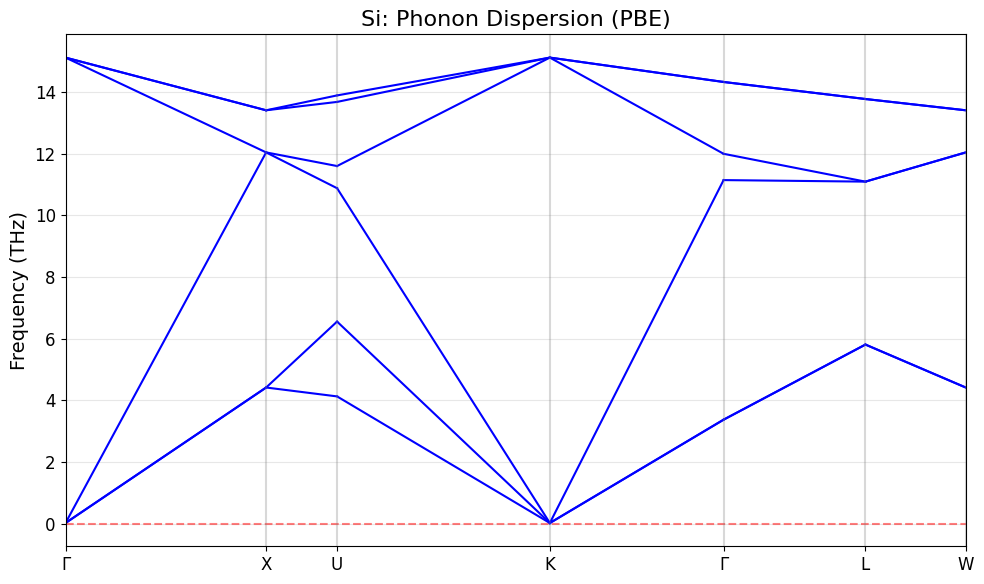


✓ Phonon dispersion saved: /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs/07_stability_Si_20260206_024221/Si_phonon_dispersion.png
  Minimum frequency: 0.02 THz
  ✓ No imaginary frequencies → Si is dynamically STABLE

  Experimental Si phonon frequencies at Γ:
    Optical (TO/LO): ~15.5 THz


In [6]:
# =============================================================================
# 2.2 COMPUTE FORCE CONSTANTS AND PLOT PHONON DISPERSION
# =============================================================================

if PHONOPY_AVAILABLE and len(all_forces) == n_disp:
    # Set forces in phonopy
    phonon.forces = all_forces
    
    # Compute force constants
    phonon.produce_force_constants()
    
    print("Force constants computed successfully!")
    
    # Set up band path using seekpath or manual
    try:
        import seekpath
        cell_tuple = (
            atoms.get_cell().tolist(),
            atoms.get_scaled_positions().tolist(),
            atoms.get_atomic_numbers().tolist(),
        )
        path_data = seekpath.get_path(cell_tuple)
        
        # Build band path for phonopy
        band_labels = []
        band_paths = []
        for start, end in path_data['path']:
            k_start = path_data['point_coords'][start]
            k_end = path_data['point_coords'][end]
            band_paths.append([k_start, k_end])
            if not band_labels or band_labels[-1] != start:
                band_labels.append(start)
            band_labels.append(end)
        
        phonon.run_band_structure(band_paths, labels=band_labels, with_eigenvectors=False)
        print(f"Band path: {' → '.join(band_labels)}")
    except ImportError:
        # Manual FCC path
        band_paths = [
            [[0, 0, 0], [0.5, 0, 0.5]],      # Γ-X
            [[0.5, 0, 0.5], [0.5, 0.25, 0.75]], # X-W
            [[0.5, 0.25, 0.75], [0.375, 0.375, 0.75]], # W-K
            [[0.375, 0.375, 0.75], [0, 0, 0]],  # K-Γ
            [[0, 0, 0], [0.5, 0.5, 0.5]],       # Γ-L
        ]
        band_labels = ['Γ', 'X', 'W', 'K', 'Γ', 'L']
        phonon.run_band_structure(band_paths, labels=band_labels)
    
    # Extract band data
    band_dict = phonon.get_band_structure_dict()
    distances = band_dict['distances']
    frequencies = band_dict['frequencies']
    
    # Check for imaginary frequencies (dynamic instability)
    all_freqs = np.concatenate([f.flatten() for f in frequencies])
    min_freq = all_freqs.min()
    has_imaginary = min_freq < -0.5  # THz threshold for instability
    
    # Plot phonon dispersion
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for seg_dist, seg_freq in zip(distances, frequencies):
        for band_idx in range(seg_freq.shape[1]):
            ax.plot(seg_dist, seg_freq[:, band_idx], 'b-', linewidth=1.5)
    
    ax.axhline(y=0, color='r', linestyle='--', alpha=0.5)
    
    # Add high-symmetry labels
    label_positions = [distances[0][0]]
    for seg in distances:
        label_positions.append(seg[-1])
    
    # Remove duplicate positions at segment boundaries
    unique_positions = [label_positions[0]]
    for p in label_positions[1:]:
        if abs(p - unique_positions[-1]) > 1e-6:
            unique_positions.append(p)
    
    for pos in unique_positions:
        ax.axvline(x=pos, color='gray', linestyle='-', alpha=0.3)
    
    ax.set_xticks(unique_positions)
    display_labels = [l.replace('GAMMA', 'Γ') for l in band_labels]
    ax.set_xticklabels(display_labels[:len(unique_positions)], fontsize=12)
    
    ax.set_ylabel('Frequency (THz)', fontsize=14)
    ax.set_title(f'{MATERIAL}: Phonon Dispersion ({FUNCTIONAL})', fontsize=16)
    ax.set_xlim(unique_positions[0], unique_positions[-1])
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    fig_path = WORK_DIR / f'{MATERIAL}_phonon_dispersion.png'
    fig.savefig(fig_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ Phonon dispersion saved: {fig_path}")
    print(f"  Minimum frequency: {min_freq:.2f} THz")
    
    if has_imaginary:
        print(f"  ✗ IMAGINARY FREQUENCIES DETECTED → {MATERIAL} is dynamically UNSTABLE!")
        dynamic_stable = False
    else:
        print(f"  ✓ No imaginary frequencies → {MATERIAL} is dynamically STABLE")
        dynamic_stable = True
    
    # Si experimental phonon frequencies for comparison
    print(f"\n  Experimental Si phonon frequencies at Γ:")
    print(f"    Optical (TO/LO): ~15.5 THz")
    
else:
    print("⚠ Phonon calculation skipped (phonopy not available or forces incomplete)")
    dynamic_stable = None

---

## 3. Mechanical Stability (Elastic Constants)

### Born Stability Criteria

For a crystal to be mechanically stable, the elastic constant matrix must be positive definite. This translates to specific inequalities depending on crystal symmetry.

### Cubic Crystals (3 independent constants: C11, C12, C44)

| Criterion | Physical Meaning |
|-----------|-----------------|
| C11 > 0 | Resistance to uniaxial strain |
| C44 > 0 | Resistance to shear |
| C11 - C12 > 0 | Tetragonal shear stability |
| C11 + 2C12 > 0 | Bulk stability |

### Hexagonal Crystals (5 independent constants)

| Criterion | Physical Meaning |
|-----------|-----------------|
| C11 > abs(C12) | In-plane stability |
| C44 > 0 | Basal shear |
| C66 > 0 | Where C66 = (C11-C12)/2 |
| C33(C11+C12) > 2C13^2 | Out-of-plane stability |

### How to Calculate Elastic Constants

**Method 1: Stress-strain (thermo_pw or ElaStic)**
- Apply small strains to the cell
- Calculate resulting stress
- Extract elastic tensor from stress-strain relation

**Method 2: Energy-strain**
- Apply strains and calculate total energy
- Fit E(strain) to extract elastic constants

In [7]:
# =============================================================================
# 3.1 ELASTIC CONSTANTS VIA STRESS-STRAIN METHOD
# =============================================================================
# For cubic crystals (Si), there are 3 independent elastic constants:
#   C11, C12, C44
#
# Method: Apply small strains, compute stress, extract C_ij
#   σ_ij = C_ijkl × ε_kl
#
# We use two strain patterns:
#   1. Volumetric strain (ε_11 = ε_22 = ε_33 = δ) → gives C11 + 2*C12
#   2. Tetragonal strain (ε_11 = δ, ε_22 = ε_33 = -δ/2) → gives C11 - C12
#   3. Shear strain (ε_23 = ε_32 = δ/2) → gives C44
# =============================================================================

delta = 0.005  # 0.5% strain

# Define strain matrices
strain_patterns = {
    'volumetric': np.array([[delta, 0, 0], [0, delta, 0], [0, 0, delta]]),
    'tetragonal': np.array([[delta, 0, 0], [0, -delta/2, 0], [0, 0, -delta/2]]),
    'shear': np.array([[0, 0, 0], [0, 0, delta/2], [0, delta/2, 0]]),
}

print(f"Elastic Constants Calculation: {MATERIAL}")
print("=" * 60)
print(f"Strain magnitude: δ = {delta} ({delta*100:.1f}%)")
print(f"Strain patterns: volumetric, tetragonal, shear")
print("=" * 60)

stress_results = {}

for pattern_name, strain in strain_patterns.items():
    stresses_pos_neg = {}
    
    for sign, sign_name in [(+1, 'pos'), (-1, 'neg')]:
        # Apply strain to cell
        cell0 = atoms.get_cell().copy()
        identity = np.eye(3)
        strained_cell = cell0 @ (identity + sign * strain)
        
        atoms_strained = atoms.copy()
        atoms_strained.set_cell(strained_cell, scale_atoms=True)
        
        prefix_el = f'elastic_{pattern_name}_{sign_name}'
        input_file = WORK_DIR / f'{prefix_el}.in'
        
        input_data = {
            'control': {
                'calculation': 'scf',
                'prefix': prefix_el,
                'outdir': './tmp',
                'pseudo_dir': str(get_pseudo_dir(FUNCTIONAL)),
                'tprnfor': True,
                'tstress': True,
            },
            'system': {
                'ecutwfc': ecutwfc,
                'ecutrho': ecutrho,
                'occupations': 'smearing',
                'smearing': 'cold',
                'degauss': 0.01,
            },
            'electrons': {'conv_thr': 1.0e-8},
        }
        
        write_espresso_in(input_file, atoms_strained, input_data=input_data,
                          pseudopotentials=pseudopotentials, kpts=(kgrid, kgrid, kgrid))
        
        output, elapsed, converged = run_qe(input_file, nprocs=NPROCS)
        
        if converged:
            # Parse full stress tensor from output
            stress_tensor = None
            lines = output.split('\n')
            for li, line in enumerate(lines):
                if 'total   stress' in line:
                    stress_tensor = np.zeros((3, 3))
                    for row in range(3):
                        parts = lines[li + 1 + row].split()
                        # The kbar values are in columns 3,4,5
                        stress_tensor[row] = [float(parts[3]), float(parts[4]), float(parts[5])]
            
            if stress_tensor is not None:
                stresses_pos_neg[sign_name] = stress_tensor
                print(f"  ✓ {pattern_name} {sign_name}: P = {np.trace(stress_tensor)/3:.2f} kbar")
            else:
                print(f"  ✗ {pattern_name} {sign_name}: Could not parse stress tensor")
        else:
            print(f"  ✗ {pattern_name} {sign_name}: SCF did not converge")
    
    stress_results[pattern_name] = stresses_pos_neg

print(f"\n{'='*60}")
print(f"All strain calculations complete")
print(f"{'='*60}")

Elastic Constants Calculation: Si
Strain magnitude: δ = 0.005 (0.5%)
Strain patterns: volumetric, tetragonal, shear
Running: /usr/bin/mpirun -np 4 /home/niel/src/qe-7.5/bin/pw.x -in elastic_volumetric_pos.in


  ✓ Converged in 85.5s
  ✓ volumetric pos: P = -13.13 kbar
Running: /usr/bin/mpirun -np 4 /home/niel/src/qe-7.5/bin/pw.x -in elastic_volumetric_neg.in


  ✓ Converged in 90.0s
  ✓ volumetric neg: P = 13.50 kbar
Running: /usr/bin/mpirun -np 4 /home/niel/src/qe-7.5/bin/pw.x -in elastic_tetragonal_pos.in


  ✓ Converged in 192.6s
  ✓ tetragonal pos: P = -0.28 kbar
Running: /usr/bin/mpirun -np 4 /home/niel/src/qe-7.5/bin/pw.x -in elastic_tetragonal_neg.in


  ✓ Converged in 188.2s
  ✓ tetragonal neg: P = -0.28 kbar
Running: /usr/bin/mpirun -np 4 /home/niel/src/qe-7.5/bin/pw.x -in elastic_shear_pos.in


  ✓ Converged in 337.2s
  ✓ shear pos: P = -0.25 kbar
Running: /usr/bin/mpirun -np 4 /home/niel/src/qe-7.5/bin/pw.x -in elastic_shear_neg.in


  ✓ Converged in 325.7s
  ✓ shear neg: P = -0.25 kbar

All strain calculations complete


In [8]:
# =============================================================================
# 3.2 EXTRACT ELASTIC CONSTANTS AND CHECK BORN STABILITY
# =============================================================================

# Extract C_ij from stress-strain data using central differences
# Standard convention: σ = C × ε (positive σ = tension)
# QE convention: negative stress = tension (opposite sign)
# Therefore: C = -(σ_QE_pos - σ_QE_neg) / (2δ)

GPa_per_kbar = 0.1  # 1 kbar = 0.1 GPa

C11 = None
C12 = None
C44 = None
C11_plus_2C12 = None
C11_minus_C12 = None

# From volumetric strain: σ_11 = (C11 + 2*C12) * δ
if 'pos' in stress_results.get('volumetric', {}) and 'neg' in stress_results.get('volumetric', {}):
    s_pos = stress_results['volumetric']['pos']
    s_neg = stress_results['volumetric']['neg']
    # Negate QE stress to get standard convention, then central difference
    ds11_vol = -(s_pos[0,0] - s_neg[0,0]) / (2 * delta)
    C11_plus_2C12 = ds11_vol * GPa_per_kbar
    print(f"From volumetric strain: C11 + 2*C12 = {C11_plus_2C12:.1f} GPa")

# From tetragonal strain (ε_11=δ, ε_22=ε_33=-δ/2):
#   σ_11 = C11*δ + C12*(-δ/2) + C12*(-δ/2) = (C11 - C12)*δ
#   σ_22 = C12*δ + C11*(-δ/2) + C12*(-δ/2) = (C12 - (C11+C12)/2)*δ
# Difference: σ_11 - σ_22 = (3/2)*(C11 - C12)*δ
if 'pos' in stress_results.get('tetragonal', {}) and 'neg' in stress_results.get('tetragonal', {}):
    s_pos = stress_results['tetragonal']['pos']
    s_neg = stress_results['tetragonal']['neg']
    # Negate QE stress
    ds11_tet = -(s_pos[0,0] - s_neg[0,0]) / (2 * delta)
    ds22_tet = -(s_pos[1,1] - s_neg[1,1]) / (2 * delta)
    C11_minus_C12 = (ds11_tet - ds22_tet) * GPa_per_kbar / 1.5
    print(f"From tetragonal strain: C11 - C12 = {C11_minus_C12:.1f} GPa")

# Solve for C11 and C12
if C11_plus_2C12 is not None and C11_minus_C12 is not None:
    C11 = (C11_plus_2C12 + 2 * C11_minus_C12) / 3
    C12 = (C11_plus_2C12 - C11_minus_C12) / 3

# From shear strain (ε_23 = δ/2): σ_23 = C44 * δ
if 'pos' in stress_results.get('shear', {}) and 'neg' in stress_results.get('shear', {}):
    s_pos = stress_results['shear']['pos']
    s_neg = stress_results['shear']['neg']
    # Negate QE stress
    ds23 = -(s_pos[1,2] - s_neg[1,2]) / (2 * delta)
    C44 = ds23 * GPa_per_kbar

# Print results
print(f"\n{'='*60}")
print(f"ELASTIC CONSTANTS: {MATERIAL} ({FUNCTIONAL})")
print(f"{'='*60}")

# Si experimental values
C11_exp, C12_exp, C44_exp = 166.0, 64.0, 80.0  # GPa

if C11 is not None and C12 is not None and C44 is not None:
    print(f"\n{'Property':<12} {'Calculated':<15} {'Experiment':<15} {'Error'}")
    print(f"{'-'*55}")
    print(f"{'C11 (GPa)':<12} {C11:<15.1f} {C11_exp:<15.1f} {(C11-C11_exp)/C11_exp*100:+.1f}%")
    print(f"{'C12 (GPa)':<12} {C12:<15.1f} {C12_exp:<15.1f} {(C12-C12_exp)/C12_exp*100:+.1f}%")
    print(f"{'C44 (GPa)':<12} {C44:<15.1f} {C44_exp:<15.1f} {(C44-C44_exp)/C44_exp*100:+.1f}%")
    
    # Derived quantities
    B_voigt = (C11 + 2*C12) / 3
    G_voigt = (C11 - C12 + 3*C44) / 5
    A_zener = 2*C44 / (C11 - C12)  # Zener anisotropy ratio
    
    print(f"\n{'Bulk modulus B (GPa)':<25} {B_voigt:.1f}")
    print(f"{'Shear modulus G (GPa)':<25} {G_voigt:.1f}")
    print(f"{'Zener anisotropy A':<25} {A_zener:.2f}  (1.0 = isotropic)")
    
    # Born stability criteria for cubic crystals
    print(f"\n{'='*60}")
    print(f"BORN STABILITY CRITERIA (Cubic)")
    print(f"{'='*60}")
    
    criteria = {
        'C11 > 0': C11 > 0,
        'C44 > 0': C44 > 0,
        'C11 > |C12|': C11 > abs(C12),
        'C11 + 2*C12 > 0': (C11 + 2*C12) > 0,
    }
    
    all_pass = True
    for criterion, passed in criteria.items():
        status = '✓ PASS' if passed else '✗ FAIL'
        if not passed:
            all_pass = False
        print(f"  {criterion:<25} {status}")
    
    mechanical_stable = all_pass
    print(f"\n→ {MATERIAL} is mechanically {'STABLE' if all_pass else 'UNSTABLE'}")
else:
    print("⚠ Could not extract all elastic constants")
    mechanical_stable = None

print(f"{'='*60}")

From volumetric strain: C11 + 2*C12 = 266.3 GPa
From tetragonal strain: C11 - C12 = 96.4 GPa

ELASTIC CONSTANTS: Si (PBE)

Property     Calculated      Experiment      Error
-------------------------------------------------------
C11 (GPa)    153.0           166.0           -7.8%
C12 (GPa)    56.6            64.0            -11.5%
C44 (GPa)    99.2            80.0            +24.0%

Bulk modulus B (GPa)      88.8
Shear modulus G (GPa)     78.8
Zener anisotropy A        2.06  (1.0 = isotropic)

BORN STABILITY CRITERIA (Cubic)
  C11 > 0                   ✓ PASS
  C44 > 0                   ✓ PASS
  C11 > |C12|               ✓ PASS
  C11 + 2*C12 > 0           ✓ PASS

→ Si is mechanically STABLE


---

## 4. Complete Stability Assessment

All three stability tests must pass before proceeding to property calculations.

In [9]:
# =============================================================================
# COMPLETE STABILITY ASSESSMENT
# =============================================================================

print("=" * 70)
print(f"STABILITY ASSESSMENT: {MATERIAL} ({FUNCTIONAL})")
print("=" * 70)

# 1. Thermodynamic
thermo_stable = True  # Elemental Si is stable by definition
print(f"\n1. THERMODYNAMIC STABILITY")
print(f"   Formation energy: 0 eV/atom (elemental reference)")
print(f"   Status: ✓ STABLE")

# 2. Dynamic
print(f"\n2. DYNAMIC STABILITY (Phonons)")
if dynamic_stable is True:
    print(f"   No imaginary frequencies detected")
    print(f"   Status: ✓ STABLE")
elif dynamic_stable is False:
    print(f"   Imaginary frequencies detected!")
    print(f"   Status: ✗ UNSTABLE")
else:
    print(f"   Status: ⚠ NOT TESTED")

# 3. Mechanical
print(f"\n3. MECHANICAL STABILITY (Born Criteria)")
if mechanical_stable is True:
    print(f"   All Born criteria satisfied")
    if C11 is not None:
        print(f"   C11={C11:.1f}, C12={C12:.1f}, C44={C44:.1f} GPa")
    print(f"   Status: ✓ STABLE")
elif mechanical_stable is False:
    print(f"   Born criteria NOT satisfied!")
    print(f"   Status: ✗ UNSTABLE")
else:
    print(f"   Status: ⚠ NOT TESTED")

# Overall
all_stable = all(s is True for s in [thermo_stable, dynamic_stable, mechanical_stable])
print(f"\n{'='*70}")
if all_stable:
    print(f"✓ {MATERIAL} PASSES ALL THREE STABILITY TESTS")
    print(f"  → Safe to proceed with property calculations (NB08, NB09)")
else:
    tests_missing = sum(1 for s in [thermo_stable, dynamic_stable, mechanical_stable] if s is None)
    if tests_missing > 0:
        print(f"⚠ {tests_missing} test(s) could not be completed")
    else:
        print(f"✗ {MATERIAL} FAILS one or more stability tests!")
print("=" * 70)

STABILITY ASSESSMENT: Si (PBE)

1. THERMODYNAMIC STABILITY
   Formation energy: 0 eV/atom (elemental reference)
   Status: ✓ STABLE

2. DYNAMIC STABILITY (Phonons)
   No imaginary frequencies detected
   Status: ✓ STABLE

3. MECHANICAL STABILITY (Born Criteria)
   All Born criteria satisfied
   C11=153.0, C12=56.6, C44=99.2 GPa
   Status: ✓ STABLE

✓ Si PASSES ALL THREE STABILITY TESTS
  → Safe to proceed with property calculations (NB08, NB09)


In [10]:
# =============================================================================
# SAVE STABILITY RESULTS TO CONVERGED PARAMETERS
# =============================================================================

params_file = WORKSHOP_ROOT / 'converged_parameters.json'
if params_file.exists():
    with open(params_file, 'r') as f:
        params = json.load(f)
else:
    params = {}

stability_data = {
    'thermodynamic': {'stable': True, 'E_form_eV_per_atom': 0.0},
    'dynamic': {'stable': dynamic_stable},
    'mechanical': {'stable': mechanical_stable},
}

if C11 is not None:
    stability_data['elastic_constants_GPa'] = {
        'C11': round(C11, 1),
        'C12': round(C12, 1),
        'C44': round(C44, 1),
        'B_voigt': round(B_voigt, 1),
    }

params['stability'] = stability_data

with open(params_file, 'w') as f:
    json.dump(params, f, indent=2)

print(f"Stability results saved to: {params_file}")

Stability results saved to: /home/niel/git/DFT_Tutorial/qe_workshop_complete/converged_parameters.json


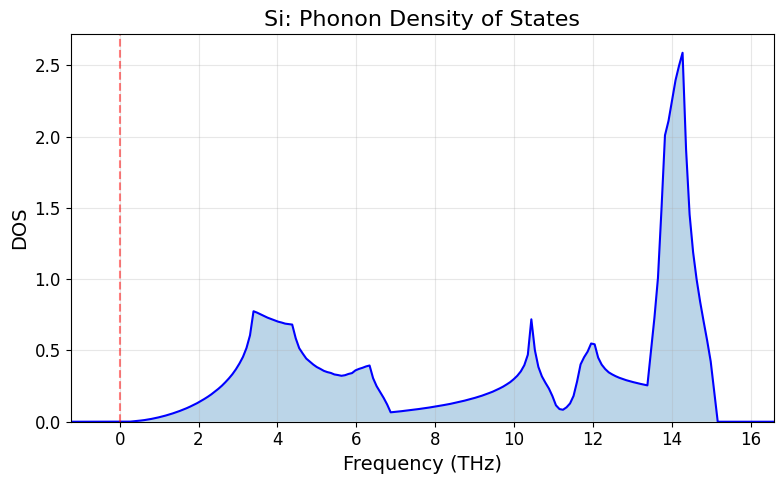

✓ Phonon DOS saved: /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs/07_stability_Si_20260206_024221/Si_phonon_dos.png


In [11]:
# =============================================================================
# PHONON DOS (if phonopy available)
# =============================================================================

if PHONOPY_AVAILABLE and len(all_forces) == n_disp:
    # Compute phonon DOS on a mesh
    phonon.run_mesh([20, 20, 20])
    phonon.run_total_dos()
    
    dos_dict = phonon.get_total_dos_dict()
    freq_dos = dos_dict['frequency_points']
    total_dos = dos_dict['total_dos']
    
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(freq_dos, total_dos, 'b-', linewidth=1.5)
    ax.fill_between(freq_dos, 0, total_dos, alpha=0.3)
    ax.axvline(x=0, color='r', linestyle='--', alpha=0.5)
    ax.set_xlabel('Frequency (THz)', fontsize=14)
    ax.set_ylabel('DOS', fontsize=14)
    ax.set_title(f'{MATERIAL}: Phonon Density of States', fontsize=16)
    ax.set_xlim(freq_dos.min(), freq_dos.max())
    ax.set_ylim(0, None)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    fig_path = WORK_DIR / f'{MATERIAL}_phonon_dos.png'
    fig.savefig(fig_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Phonon DOS saved: {fig_path}")
else:
    print("Phonon DOS skipped (phonopy not available or forces incomplete)")

In [12]:
# =============================================================================
# COMPARISON WITH EXPERIMENTAL VALUES
# =============================================================================

print(f"\n{'='*70}")
print(f"COMPARISON WITH EXPERIMENT: {MATERIAL}")
print(f"{'='*70}")

print(f"\n{'Property':<30} {'Calculated':<15} {'Experiment':<15}")
print(f"{'-'*60}")

if C11 is not None:
    print(f"{'C11 (GPa)':<30} {C11:<15.1f} {166.0:<15.1f}")
    print(f"{'C12 (GPa)':<30} {C12:<15.1f} {64.0:<15.1f}")
    print(f"{'C44 (GPa)':<30} {C44:<15.1f} {80.0:<15.1f}")
    print(f"{'Bulk modulus B (GPa)':<30} {B_voigt:<15.1f} {99.0:<15.1f}")

if PHONOPY_AVAILABLE and len(all_forces) == n_disp:
    # Get max optical frequency
    max_freq = all_freqs.max()
    print(f"{'Max phonon freq (THz)':<30} {max_freq:<15.1f} {'~15.5':<15}")

print(f"\n{'='*70}")
print(f"\nNote: PBE typically underestimates elastic constants by ~10-15%")
print(f"and slightly overestimates phonon frequencies.")


COMPARISON WITH EXPERIMENT: Si

Property                       Calculated      Experiment     
------------------------------------------------------------
C11 (GPa)                      153.0           166.0          
C12 (GPa)                      56.6            64.0           
C44 (GPa)                      99.2            80.0           
Bulk modulus B (GPa)           88.8            99.0           
Max phonon freq (THz)          15.1            ~15.5          


Note: PBE typically underestimates elastic constants by ~10-15%
and slightly overestimates phonon frequencies.


In [13]:
# =============================================================================
# LIST OUTPUT FILES
# =============================================================================

print(f"Output files in: {WORK_DIR}")
print("=" * 60)

output_files = sorted(WORK_DIR.glob('*.png'))
for f in output_files:
    print(f"  📊 {f.name}")

n_inputs = len(list(WORK_DIR.glob('*.in')))
n_outputs = len(list(WORK_DIR.glob('*.out')))
print(f"\n  {n_inputs} QE input files")
print(f"  {n_outputs} QE output files")
print(f"  Stability results: {params_file}")
print("=" * 60)

Output files in: /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs/07_stability_Si_20260206_024221
  📊 Si_phonon_dispersion.png
  📊 Si_phonon_dos.png

  8 QE input files
  8 QE output files
  Stability results: /home/niel/git/DFT_Tutorial/qe_workshop_complete/converged_parameters.json


---

## Summary: Stability Analysis Checklist

Before proceeding to property calculations, ensure ALL tests pass:

| Test | Method | Threshold | Package |
|------|--------|-----------|---------|
| **Thermodynamic** | Formation energy + Convex hull | Ehull < 25 meV/atom | pymatgen |
| **Dynamic** | DFPT phonons (ph.x) | No imaginary modes | QE ph.x |
| **Mechanical** | Elastic constants | Born criteria satisfied | QE/thermo_pw |

### If Tests Fail

| Failed Test | Possible Actions |
|-------------|-----------------|
| Thermodynamic | Check competing phases, try different stoichiometry |
| Dynamic | Re-optimize structure, try different magnetic order |
| Mechanical | Check calculation convergence, verify structure |

### Key Points

1. **Never skip stability tests** - unstable materials give meaningless properties
2. **Use established packages** (pymatgen, phonopy) for reliable results
3. **Compare with literature** - known stable materials should pass all tests
4. **Document your results** - stability data is required for publications

### Next Steps

After ALL stability tests pass:
- Proceed to **Notebook 08: Electronic Properties** (band structure, DOS)
- Calculate optical, thermal, and transport properties (Notebook 09)